In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib qt

Gradient decay
==========================================

Some results worth saving and displaying for visualization and understanding

1/ Decay of gradient variances with increasing qubit count
---------------------------

First importing the relevant packages

In [2]:
import sys
sys.path.append('../src')
sys.path.append('src')
import matplotlib.pyplot as plt
import numpy as np
from gadget_plots import *
from data_management import get_training_costs, get_training_labels2, get_training_info

data_folder = '../../results/data/'

colours = np.array([plt.cm.Purples(np.linspace(0, 1, 6)),          # global
                    plt.cm.Blues(np.linspace(0, 1, 6)),            # local
                    plt.cm.Oranges(np.linspace(0, 1, 6)),          # gadget2
                    plt.cm.Reds(np.linspace(0, 1, 6)),             # gadget3
                    plt.cm.Greys(np.linspace(0, 1, 6))])[:, 1:]    # legends

Exponential decay of the global Hamiltonian
$$H_G = \bigotimes_{i=1}^n \sigma_i^z $$

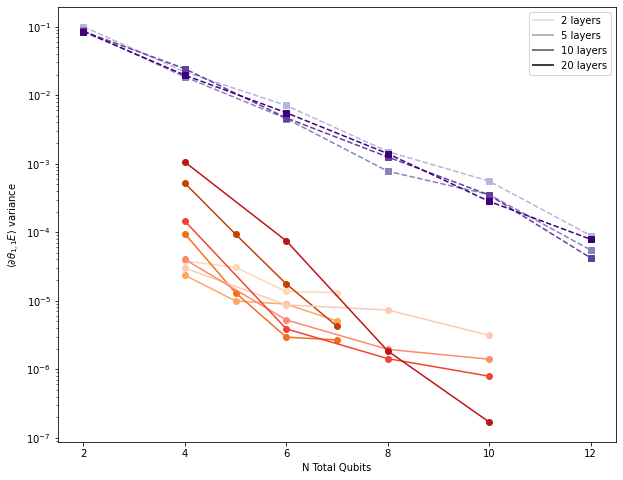

In [3]:
file_comp = data_folder + 'gradients/220707/gradients_nr0001.npz'
file_gad3 = data_folder + 'gradients/220708_euler/gradients_nr0001.npz'
file_gad4 = data_folder + 'gradients/220708_qmio/gradients_nr0002.npz'
layers_list = [2, 5, 10, 20]

data = np.load(file_comp)
variances_list = data['variances_list']
norms_list = data['norms_list']
qubits_list = data['width_list']

plt.rcParams["figure.figsize"] = 10, 8
fig, ax = plt.subplots()
for line in range(1, len(variances_list)-1):
    normalized_variances = variances_list[line]/norms_list**2
    ax.semilogy(qubits_list, normalized_variances, "--s", c=colours[0][line])

data = np.load(file_gad3)
variances_list = data['variances_list']
norms_list = data['norms_list']
qubits_list = data['computational_qubits'][:4]

for line in range(len(variances_list)):
    # normalized_variances = variances_list[line]/norms_list**2
    normalized_variances = variances_list[line]
    ax.semilogy(qubits_list, normalized_variances, "-o", c=colours[2][line])

data = np.load(file_gad4)
variances_list = data['variances_list']
norms_list = data['norms_list']
qubits_list = data['computational_qubits'][:4]

for line in range(len(variances_list)):
    # normalized_variances = variances_list[line]/norms_list**2
    normalized_variances = variances_list[line]
    ax.semilogy(qubits_list, normalized_variances, "-o", c=colours[3][line])

ax.set_xlabel(r"N Total Qubits")
ax.set_ylabel(r"$\langle \partial \theta_{1, 1} E\rangle$ variance")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

custom_lines = [Line2D([0], [0], color=colours[-1][nl], lw=2) for nl in range(len(layers_list))]
ax.legend(custom_lines, ['{} layers'.format(num_layers) for num_layers in layers_list])

In [65]:
def get_vars_for_plot(file, max_qubit=np.inf):
    data = np.load(file, allow_pickle=True)
    qubits_list = data['computational_qubits']
    layers_list = data['layers_list']
    norms_list = data['norms_list']
    gradients_dict = data['all_gradients'].item()
    variances_list=[[] for _ in range(len(layers_list))]
    cutoff_index = np.where(qubits_list == max_qubit)
    if np.shape(cutoff_index[0]) == (1,):
        widths_range = qubits_list[:cutoff_index[0][0]+1]
    else: 
        widths_range = qubits_list
    for width in widths_range:
        for nl, depth in enumerate(layers_list):
            full_gradient = np.array(gradients_dict[(width, depth)])
            param_count = np.prod(np.shape(full_gradient[1:]))
            # variances_list[nl].append(np.var(np.sum(np.abs(full_gradient), axis=(1,2))) / param_count)
            # variances_list[nl].append(np.var(np.linalg.norm(full_gradient, 'fro', axis=(1,2))) / np.sqrt(param_count))
            # variances_list[nl].append(np.var(full_gradient[:, 0, -1]))
            variances_list[nl].append(np.var(full_gradient[:, 0, width-1]))
    return widths_range, norms_list, variances_list

4
3


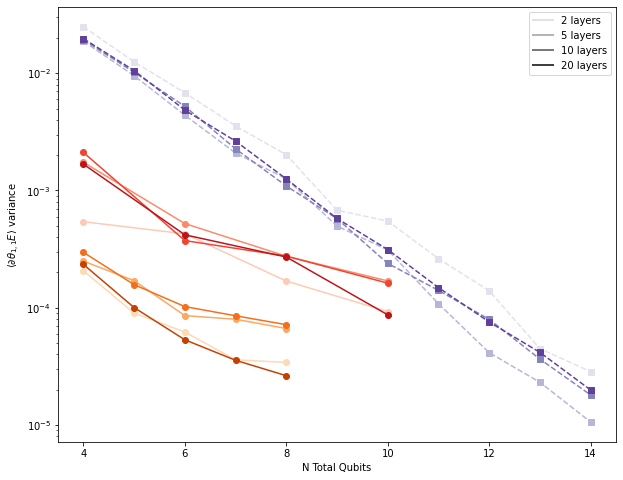

In [66]:
file_comp = data_folder + 'gradients/220711_qmio/gradients_nr0002.npz'
file_gad3 = data_folder + 'gradients/220712_euler/gradients_nr0002.npz'
file_gad4 = data_folder + 'gradients/220712_euler/gradients_nr0004.npz'

plt.rcParams["figure.figsize"] = 10, 8
fig, ax = plt.subplots()

qubits_list, norms_list, variances_list = get_vars_for_plot(file_comp)
for line in range(len(variances_list)):
    normalized_variances = variances_list[line]/norms_list**2
    ax.semilogy(qubits_list, normalized_variances, "--s", c=colours[0][line])

qubits_list, norms_list, variances_list = get_vars_for_plot(file_gad3, max_qubit=8)
for line in range(len(variances_list)):
    normalized_variances = variances_list[line]/norms_list**2
    ax.semilogy(qubits_list, normalized_variances, "-o", c=colours[2][line])

qubits_list, norms_list, variances_list = get_vars_for_plot(file_gad4, max_qubit=10)
for line in range(len(variances_list)):
    normalized_variances = variances_list[line]/norms_list**2
    ax.semilogy(qubits_list, normalized_variances, "-o", c=colours[3][line])

ax.set_xlabel(r"N Total Qubits")
ax.set_ylabel(r"$\langle \partial \theta_{1, 1} E\rangle$ variance")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

custom_lines = [Line2D([0], [0], color=colours[-1][nl], lw=2) for nl in range(len(layers_list))]
ax.legend(custom_lines, ['{} layers'.format(num_layers) for num_layers in layers_list])

In [ ]:
file = data_folder + 'gradients/220712_euler/gradients_nr0002.npz'

data = np.load(file_comp, allow_pickle=True)
qubits_list = data['widths_list']
layers_list = data['layers_list']
norms_list = data['norms_list']
gradients_dict = data['all_gradients'].item()


In [ ]:
print(gradients_dict.keys())
print(qubits_list)
print(norms_list)
print(layers_list)
print(np.shape(gradients_dict[4, 10]))
print(np.shape(np.sum(gradients_dict[4, 10], axis=(1,2))))
all_grads = np.array(gradients_dict[(4, 10)])
print(type(all_grads))
print(np.shape(all_grads[:, 0, 0]))

Training
=======

3-local gadget decomposition
---------------------

In [ ]:
def plot_single_training(file):
    plt.rcParams["figure.figsize"] = 5, 4
    costs = get_training_costs(file + '.npz')
    labels = get_training_labels2(file + '.txt')
    colors = plt.cm.rainbow(np.linspace(0, 1, len(costs)-1))
    fig, ax1 = plt.subplots()
    # ax2 = ax1.twinx()
    ax1.plot(np.ones(len(costs[0])), ':', c='gainsboro')
    ax1.plot(-np.ones(len(costs[0])), ':', c='gainsboro')
    ax1.plot(np.zeros(len(costs[0])), ':', c='gainsboro')
    for i in range(1, len(costs)):
        ax1.plot(costs[i],'-', c=colors[i-1], label=labels[i])
    ax1.plot(costs[0],':', c='grey', label='Training')
    ax1.legend()
    ax1.set_xlabel('iterations')
    ax1.set_ylabel('computational cost')
    print('Final training cost: {:4.8f}'.format(costs[0][-1]))

$\lambda = \lambda_{max}$

In [ ]:
# file_list = ['220707/training_nr0001', '220707/training_nr0002', 
#              '220707/training_nr0003', '220707/training_nr0004']
# for file in file_list:
#     plot_single_training(data_folder + '/training/' + file)

$\lambda = 5\lambda_{max}$

In [ ]:
file_list = ['220708/training_nr0005', '220708/training_nr0002', 
             '220708/training_nr0003', '220708/training_nr0004']
# for file in file_list:
#     plot_single_training(data_folder + '/training/' + file)

In [ ]:
lambdas = [0.1, 0.5, 1, 5, 10]
seeds = [2, 3, 4]

plt.rcParams["figure.figsize"] = 25, 12
fig, axs = plt.subplots(3, 5)
for s, seed in enumerate(seeds):
    for l, lamb in enumerate(lambdas):
        count = 12 + s * len(lambdas) + (l+1)
        file = data_folder + '/training/' + '220708_euler/training_nr00{}'.format(count)
        costs = get_training_costs(file + '.npz')
        labels = get_training_labels2(file + '.txt')
        colors = plt.cm.rainbow(np.linspace(0, 1, len(costs)-1))
        axs[s, l].plot(np.ones(len(costs[0])), ':', c='gainsboro')
        axs[s, l].plot(-np.ones(len(costs[0])), ':', c='gainsboro')
        axs[s, l].plot(np.zeros(len(costs[0])), ':', c='gainsboro')
        for i in range(1, len(costs)):
            axs[s, l].plot(costs[i],'-', c=colors[i-1], label=labels[i])
        axs[s, l].plot(costs[0],':', c='grey', label='Training')
        if count == 24:
            axs[s, l].legend()
            axs[s, l].set_xlabel('iterations')
        if s == 0:
            axs[s, l].set_title(r'$\lambda = {:.1f}$'.format(lamb) + r'$\lambda_{max}$')
        if l == 0:
            axs[s, l].set_ylabel('random seed: {}'.format(seed))
        print('Final training cost: {:12.8f}'.format(costs[0][-1]), 
              '    | computational cost: {:12.8f}'.format(costs[1][-1]))

Figure for the extended abstract

In [ ]:
from rsmf import CustomFormatter

formatter = CustomFormatter(
    columnwidth=347.12354 * 0.01389,
    wide_columnwidth=347.12354 * 0.01389,
    fontsizes=11,
    pgf_preamble=r"\usepackage[T1]{fontenc}",
)

In [ ]:
lambdas = [0.1, 1, 10]
seeds = [2, 3, 4]
file_list = ['220708_euler/training_nr00{}'.format(count) for count in [18, 20, 22]]
palette = ['#648FFF', '#DC267F']

fig = formatter.figure(aspect_ratio=.4, wide=True)
axs = fig.subplots(1, 3)
for f, file in enumerate(file_list):
    file = data_folder + 'training/' + file
    costs = get_training_costs(file + '.npz')
    labels = get_training_labels2(file + '.txt')
    colors = plt.cm.rainbow(np.linspace(0, 1, len(costs)-1))
    axs[f].plot(np.ones(len(costs[0])), ':', c='gainsboro')
    axs[f].plot(-np.ones(len(costs[0])), ':', c='gainsboro')
    axs[f].plot(np.zeros(len(costs[0])), ':', c='gainsboro')
    for i in range(1, 3):
        axs[f].plot(costs[i],'-', c=palette[i-1], label=labels[i])
    axs[f].set_title(r'$\lambda = {}$'.format(lambdas[f]) + r'$\lambda_{max}$')
axs[0].set_ylabel('Cost')
axs[1].set_xlabel('Number of iterations')
plt.tight_layout()
custom_lines = [Line2D([0], [0], color=palette[nl], lw=2) for nl in range(2)]
lgd = fig.legend(handles=custom_lines,
                 labels=labels[1:3], loc='lower center',
                 bbox_to_anchor=(0.1, -0.12, 0.8, 0.5),
                 mode='expand',
                 ncol=4)
plt.tight_layout()

# plt.savefig(data_folder + '../plots/training_new_gadget/trainings_for_abstract.pdf', 
#             bbox_extra_artists = (lgd,), bbox_inches='tight')
